In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pvlib

In [2]:
weather = pd.read_csv("weather_train.csv")
temp_data = pd.DataFrame(weather.tavg)
weather.index = pd.date_range(start='2012-01-01', end='2016-12-31', freq='D')

In [3]:
temp_data.index = weather.index

In [4]:
temp_data

,tavg
2012-01-01,22.1
2012-01-02,22.3
2012-01-03,23.1
2012-01-04,23.7
2012-01-05,23.3
...,...
2016-12-27,21.4
2016-12-28,21.9
2016-12-29,20.8
2016-12-30,20.4


In [5]:
import pandas as pd
import pvlib

# Set location information (latitude, longitude, and elevation)
latitude = 12.971598
longitude = 77.594562
altitude = 920
tz = 'Asia/Kolkata'

weather_data = temp_data.tavg
times = weather_data.index
location = pvlib.location.Location(latitude, longitude, tz=tz)

# Calculate solar position
solar_position = pvlib.solarposition.get_solarposition(times, latitude, longitude)

# Calculate extraterrestrial radiation
dni_extra = pvlib.irradiance.get_extra_radiation(times)

# Calculate air mass, replacing NaN values with a default value (e.g., 10)
airmass = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith']).fillna(10)

# Assuming no direct horizontal irradiance (dhi) available, set it to zero
dhi = pd.Series(0, index=times)

# Calculate the solar panel tilt and azimuth dynamically based on solar position
solar_panel_tilt = 90 - solar_position['apparent_elevation']
solar_panel_azimuth = solar_position['azimuth']

# Ensure tilt values are within a reasonable range (0 to 90 degrees)
solar_panel_tilt = solar_panel_tilt.clip(0, 90)

# Use temperature data from your CSV file
temp_air = temp_data['tavg']

# Calculate total radiation on a tilted surface with dynamic tilt and azimuth
total_irradiance_dynamic = pvlib.irradiance.get_total_irradiance(
    solar_panel_tilt, solar_panel_azimuth, solar_position['apparent_zenith'],
    solar_position['azimuth'], dni_extra, dhi, airmass)

# Convert irradiance to energy (assuming a 1 kW system)
system_size_kw = 3
energy_dynamic = total_irradiance_dynamic * system_size_kw/1000

# Create a pandas DataFrame to store the results
result_df_dynamic = pd.DataFrame(index=times)
result_df_dynamic['Energy_Generated_KWh'] = energy_dynamic['poa_global']
result_df_dynamic['Temperature_C'] = temp_air  # Use the existing temperature data

# Print the resulting DataFrame with dynamic tilt and azimuth
print(result_df_dynamic)

            Energy_Generated_KWh  Temperature_C
2012-01-01              4.071660           22.1
2012-01-02              4.069606           22.3
2012-01-03              4.067545           23.1
2012-01-04              4.065478           23.7
2012-01-05              4.063411           23.3
...                          ...            ...
2016-12-27              4.080274           21.4
2016-12-28              4.078278           21.9
2016-12-29              4.076259           20.8
2016-12-30              4.074220           20.4
2016-12-31              4.072165           20.0

[1827 rows x 2 columns]


<Axes: >

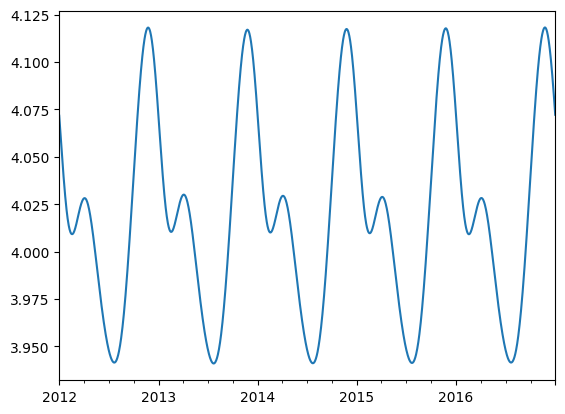

In [6]:
result_df_dynamic["Energy_Generated_KWh"].plot()

In [7]:
result_df_dynamic["Energy_Generated_KWh"] = result_df_dynamic["Energy_Generated_KWh"].shift(90).dropna()

<Axes: >

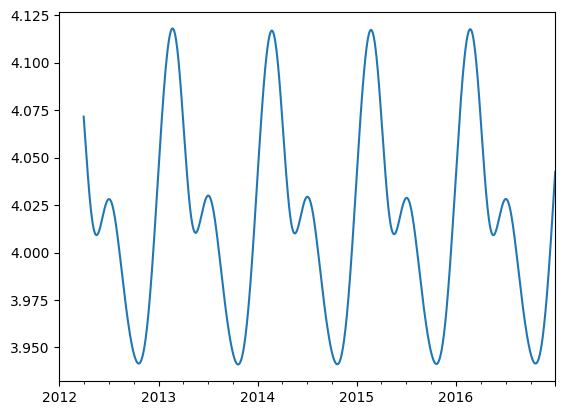

In [8]:
result_df_dynamic["Energy_Generated_KWh"].plot()

In [9]:
result_df_dynamic.dropna(inplace=True)

In [10]:
solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2012-01-01,106.996890,106.996890,-16.996890,-16.996890,110.484688,-3.071913
2012-01-02,107.094981,107.094981,-17.094981,-17.094981,110.387431,-3.545350
2012-01-03,107.190916,107.190916,-17.190916,-17.190916,110.282394,-4.013100
2012-01-04,107.284590,107.284590,-17.284590,-17.284590,110.169622,-4.474671
2012-01-05,107.375902,107.375902,-17.375902,-17.375902,110.049165,-4.929588
...,...,...,...,...,...,...
2016-12-27,106.559524,106.559524,-16.559524,-16.559524,110.806436,-1.015076
2016-12-28,106.665553,106.665553,-16.665553,-16.665553,110.742434,-1.506922
2016-12-29,106.769985,106.769985,-16.769985,-16.769985,110.670488,-1.995738
2016-12-30,106.872695,106.872695,-16.872695,-16.872695,110.590629,-2.480913


In [11]:
total_irradiance_dynamic

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2012-01-01,1357.219962,1352.219962,5.0,5.0,0.0
2012-01-02,1356.535403,1351.535403,5.0,5.0,0.0
2012-01-03,1355.848224,1350.848224,5.0,5.0,0.0
2012-01-04,1355.159472,1350.159472,5.0,5.0,0.0
2012-01-05,1354.470185,1349.470185,5.0,5.0,0.0
...,...,...,...,...,...
2016-12-27,1360.091456,1355.091456,5.0,5.0,0.0
2016-12-28,1359.426039,1354.426039,5.0,5.0,0.0
2016-12-29,1358.752944,1353.752944,5.0,5.0,0.0
2016-12-30,1358.073282,1353.073282,5.0,5.0,0.0


noise

In [12]:



import pandas as pd
import pvlib

# Set location information (latitude, longitude, and elevation)
latitude = 12.971598
longitude = 77.594562
altitude = 920
tz = 'Asia/Kolkata'

weather_data = temp_data.tavg
times = weather_data.index
location = pvlib.location.Location(latitude, longitude, tz=tz)

# Calculate solar position
solar_position = pvlib.solarposition.get_solarposition(times, latitude, longitude)

# Calculate extraterrestrial radiation
dni_extra = pvlib.irradiance.get_extra_radiation(times)

# Calculate air mass, replacing NaN values with a default value (e.g., 10)
airmass = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith']).fillna(10)

# Assuming no direct horizontal irradiance (dhi) available, set it to zero
dhi = pd.Series(0, index=times)

# Calculate the solar panel tilt and azimuth dynamically based on solar position
solar_panel_tilt = 90 - solar_position['apparent_elevation']
solar_panel_azimuth = solar_position['azimuth']

# Ensure tilt values are within a reasonable range (0 to 90 degrees)
solar_panel_tilt = solar_panel_tilt.clip(0, 90)

# Use temperature data from your CSV file
temp_air = temp_data['tavg']


# Generate random noise for temperature and irradiance
noise_temp = np.random.normal(0, 2, len(times))  # Adjust the parameters based on your preference
noise_irradiance = np.random.normal(0, 50, len(times))  # Adjust the parameters based on your preference

# Add noise to the temperature and irradiance variables
temp_air_with_noise = temp_air + noise_temp
total_irradiance_dynamic_with_noise = pvlib.irradiance.get_total_irradiance(
    solar_panel_tilt, solar_panel_azimuth, solar_position['apparent_zenith'],
    solar_position['azimuth'], dni_extra, dhi, airmass)['poa_global'] + noise_irradiance

# Convert irradiance to energy (assuming a 1 kW system)
system_size_kw = 3
energy_dynamic_with_noise = total_irradiance_dynamic_with_noise * system_size_kw / 1000

# Create a pandas DataFrame to store the results with noise
result_df_dynamic_with_noise = pd.DataFrame(index=times)
result_df_dynamic_with_noise['Energy_Generated_KWh'] = energy_dynamic_with_noise
result_df_dynamic_with_noise['Temperature_C'] = temp_air_with_noise

# Print the resulting DataFrame with noise
print(result_df_dynamic_with_noise)


            Energy_Generated_KWh  Temperature_C
2012-01-01              4.261358      19.012714
2012-01-02              4.007858      25.117008
2012-01-03              3.949377      24.858675
2012-01-04              4.133708      23.235063
2012-01-05              4.294925      22.250238
...                          ...            ...
2016-12-27              4.067669      20.830518
2016-12-28              4.025891      19.048137
2016-12-29              4.008596      18.693257
2016-12-30              4.470248      22.154205
2016-12-31              4.173275      21.854417

[1827 rows x 2 columns]


<Axes: >

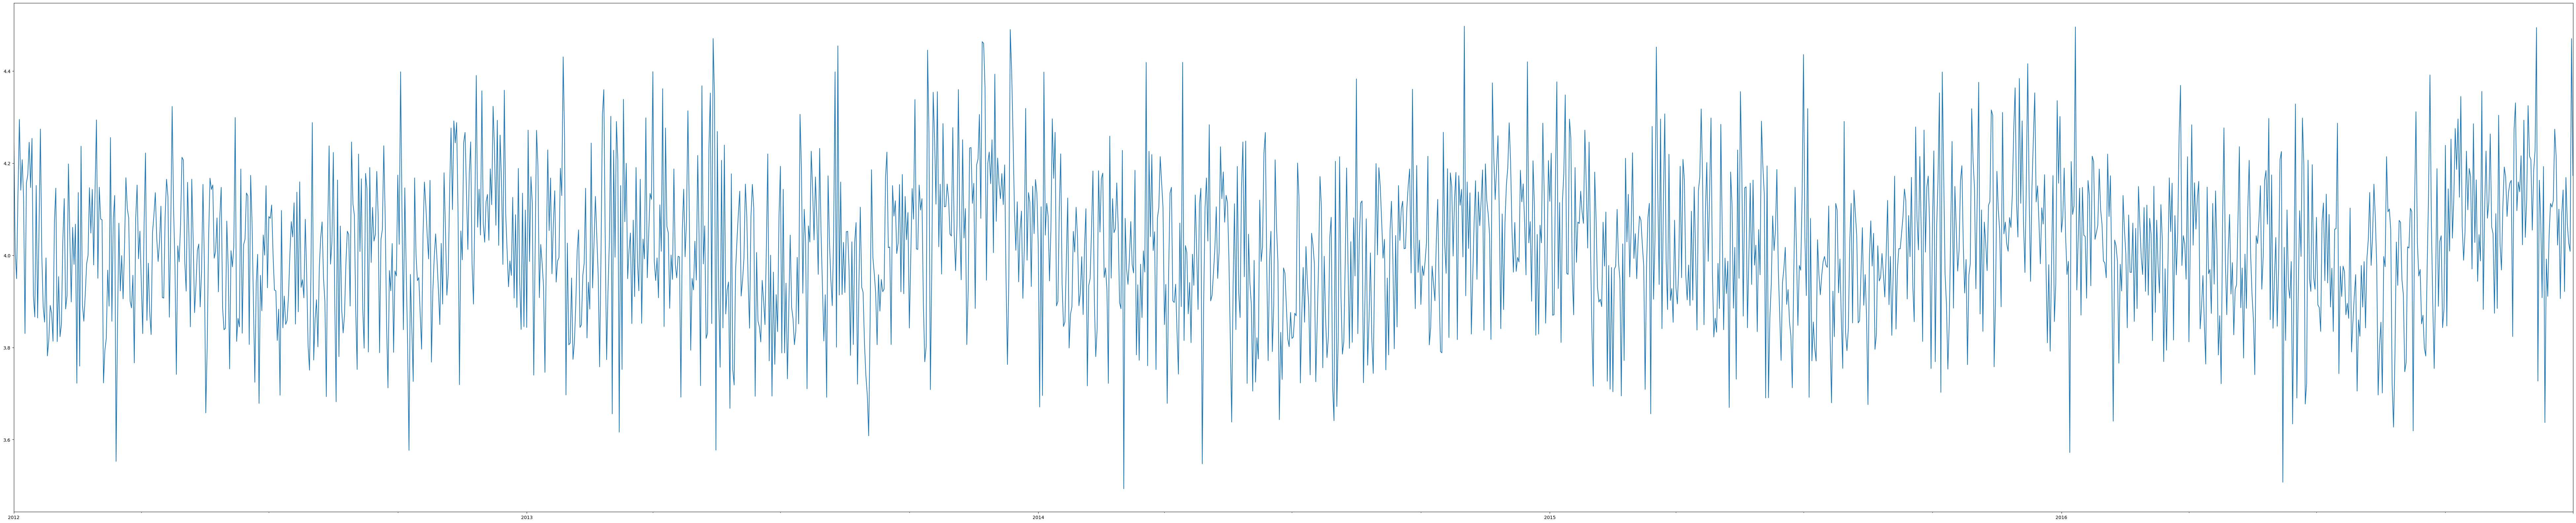

In [17]:
result_df_dynamic_with_noise['Energy_Generated_KWh'].plot(figsize=(100,20))

In [18]:
solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2012-01-01,106.996890,106.996890,-16.996890,-16.996890,110.484688,-3.071913
2012-01-02,107.094981,107.094981,-17.094981,-17.094981,110.387431,-3.545350
2012-01-03,107.190916,107.190916,-17.190916,-17.190916,110.282394,-4.013100
2012-01-04,107.284590,107.284590,-17.284590,-17.284590,110.169622,-4.474671
2012-01-05,107.375902,107.375902,-17.375902,-17.375902,110.049165,-4.929588
...,...,...,...,...,...,...
2016-12-27,106.559524,106.559524,-16.559524,-16.559524,110.806436,-1.015076
2016-12-28,106.665553,106.665553,-16.665553,-16.665553,110.742434,-1.506922
2016-12-29,106.769985,106.769985,-16.769985,-16.769985,110.670488,-1.995738
2016-12-30,106.872695,106.872695,-16.872695,-16.872695,110.590629,-2.480913


In [20]:
total_irradiance_dynamic_with_noise, temp_air

(2012-01-01    1420.452739
 2012-01-02    1335.952785
 2012-01-03    1316.459144
 2012-01-04    1377.902763
 2012-01-05    1431.641681
                  ...     
 2016-12-27    1355.889754
 2016-12-28    1341.963562
 2016-12-29    1336.198646
 2016-12-30    1490.082589
 2016-12-31    1391.091727
 Freq: D, Name: poa_global, Length: 1827, dtype: float64,
 2012-01-01    22.1
 2012-01-02    22.3
 2012-01-03    23.1
 2012-01-04    23.7
 2012-01-05    23.3
               ... 
 2016-12-27    21.4
 2016-12-28    21.9
 2016-12-29    20.8
 2016-12-30    20.4
 2016-12-31    20.0
 Freq: D, Name: tavg, Length: 1827, dtype: float64)

In [23]:
# result_df_dynamic_with_noise + solar_position["apparent_zenith"] + solar_position["azimuth"] + total_irradiance_dynamic_with_noise
final = pd.concat([result_df_dynamic_with_noise, solar_position["apparent_zenith"], solar_position["azimuth"], total_irradiance_dynamic_with_noise], axis=1)
final

,Energy_Generated_KWh,Temperature_C,apparent_zenith,azimuth,poa_global
2012-01-01,4.261358,19.012714,106.996890,110.484688,1420.452739
2012-01-02,4.007858,25.117008,107.094981,110.387431,1335.952785
2012-01-03,3.949377,24.858675,107.190916,110.282394,1316.459144
2012-01-04,4.133708,23.235063,107.284590,110.169622,1377.902763
2012-01-05,4.294925,22.250238,107.375902,110.049165,1431.641681
...,...,...,...,...,...
2016-12-27,4.067669,20.830518,106.559524,110.806436,1355.889754
2016-12-28,4.025891,19.048137,106.665553,110.742434,1341.963562
2016-12-29,4.008596,18.693257,106.769985,110.670488,1336.198646
2016-12-30,4.470248,22.154205,106.872695,110.590629,1490.082589


In [24]:
final.to_csv("gen_train.csv")